In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/preLL/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_AC_preLL_57to62keV/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_DC_preLL_57to62keV/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']], \
            'Ba133': [['20231005_Ba133_AC_600V.dat']], \
            'Na22': [['20231024_Na22_AC_600V_1.dat', '20231024_Na22_AC_600V_2.dat', '20231026_Na22_AC_600V.dat']], \
            'Am241': [['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat']]}

erange_dict = {'Cs137': [630., 667.], 'Ba133': [330., 360.], 'Na22': [1220., 1280.], 'Am241': [50., 64.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Ba133': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Na22': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Am241': np.linspace(calibrator.zmin, calibrator.zmax, 31)}

# Loop and make depth-calibrated dataframes

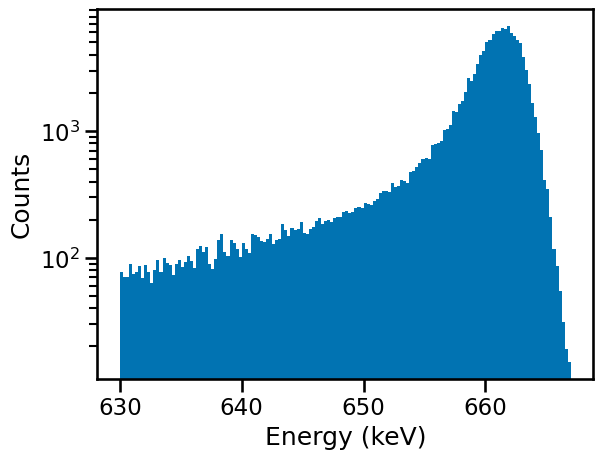

FWHM = 3.91
FWTM = 9.17


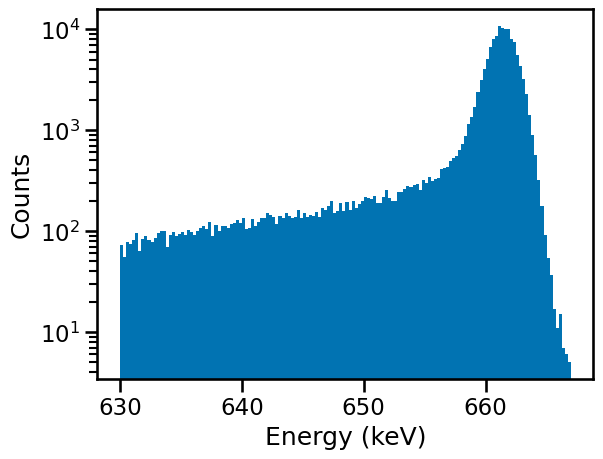

FWHM = 2.48
FWTM = 5.23


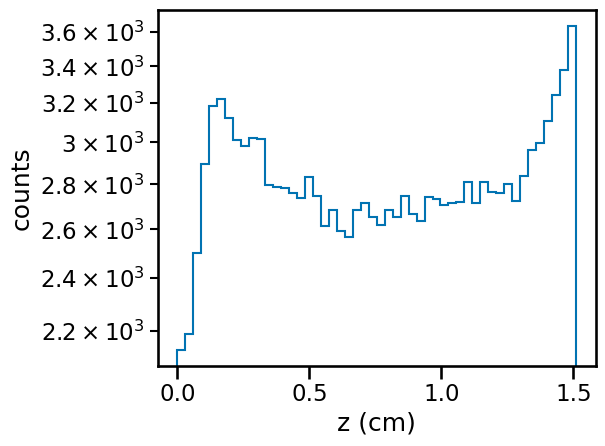

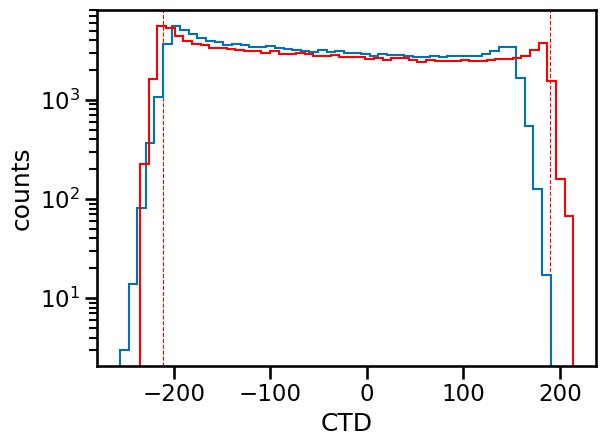

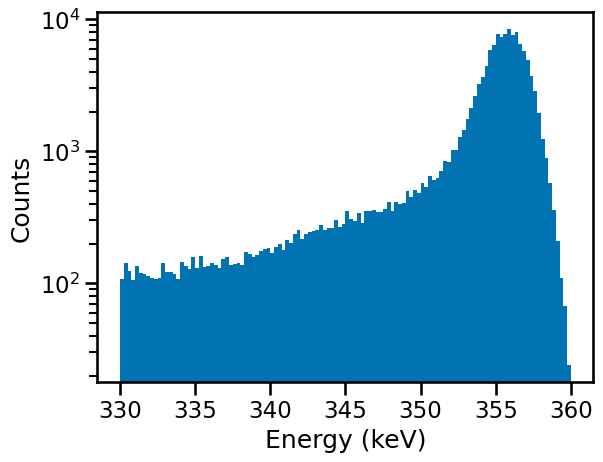

FWHM = 2.94
FWTM = 6.52


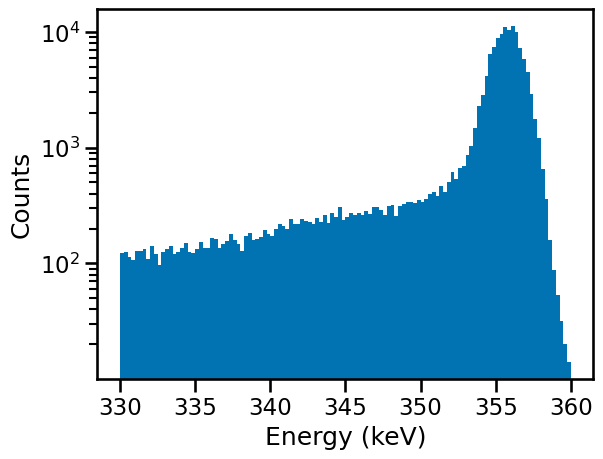

FWHM = 2.41
FWTM = 4.48


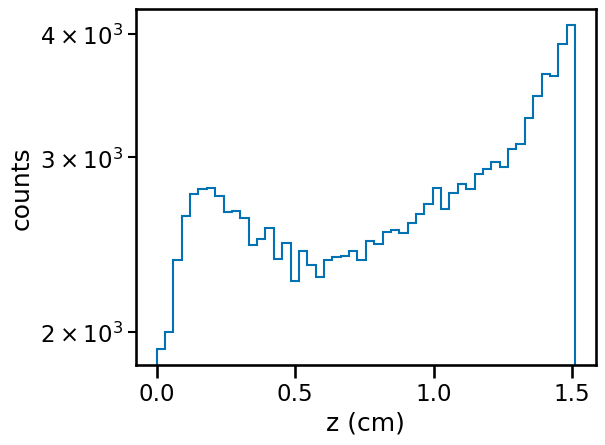

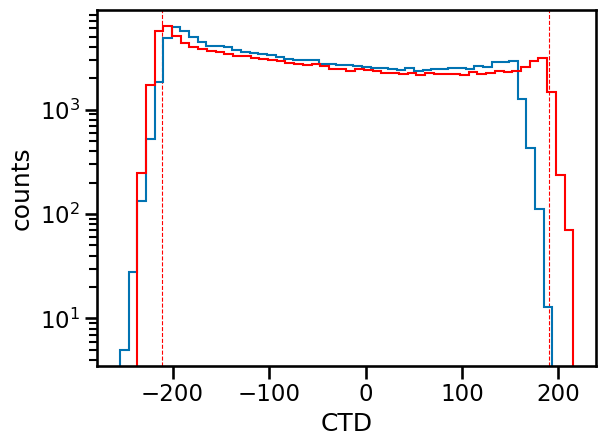

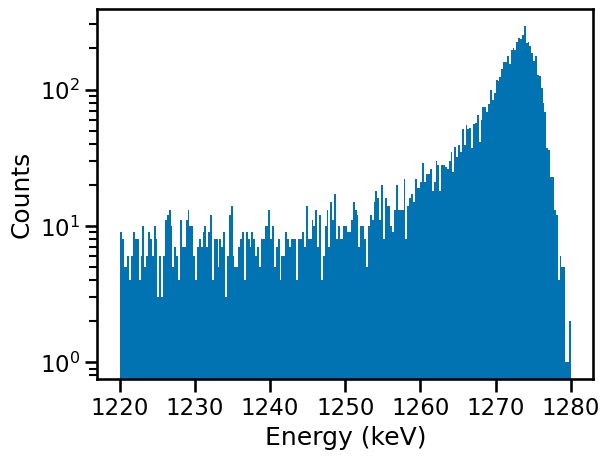

FWHM = 4.61
FWTM = 15.14


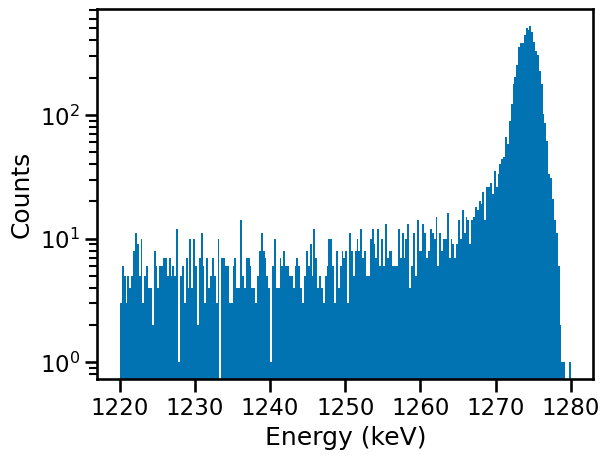

FWHM = 2.88
FWTM = 5.76


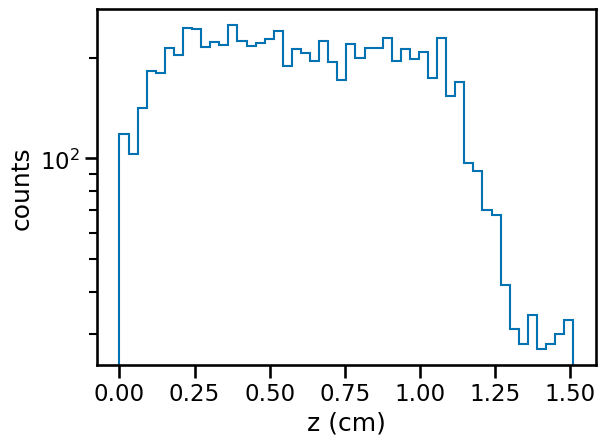

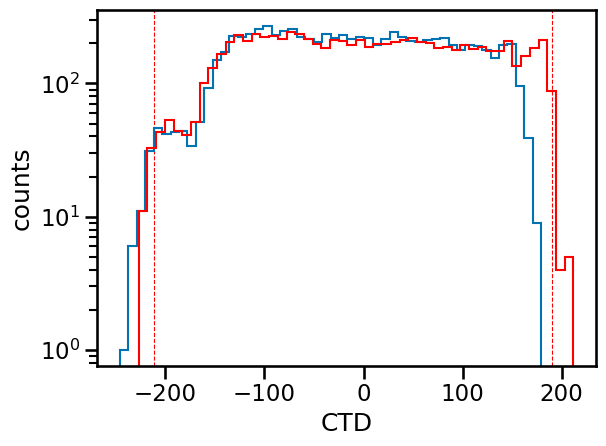

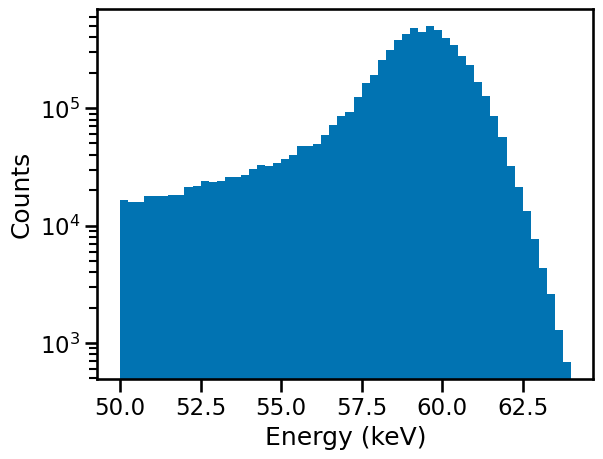

FWHM = 2.7
FWTM = 5.82


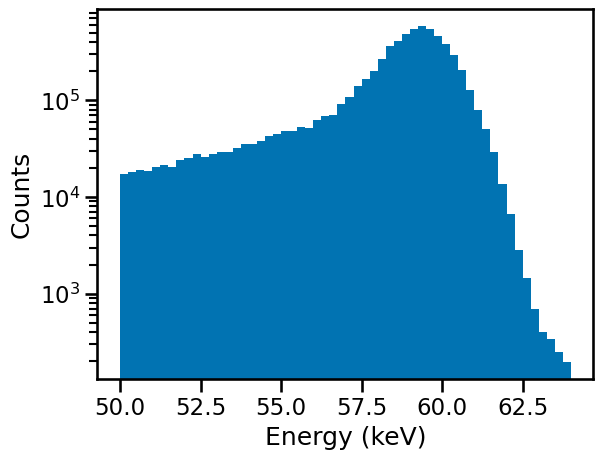

FWHM = 2.21
FWTM = 5.25


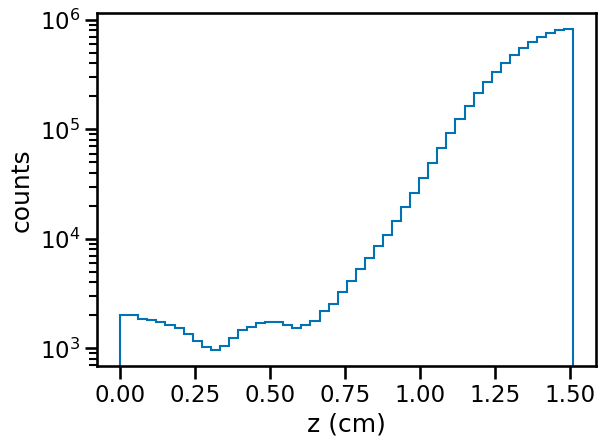

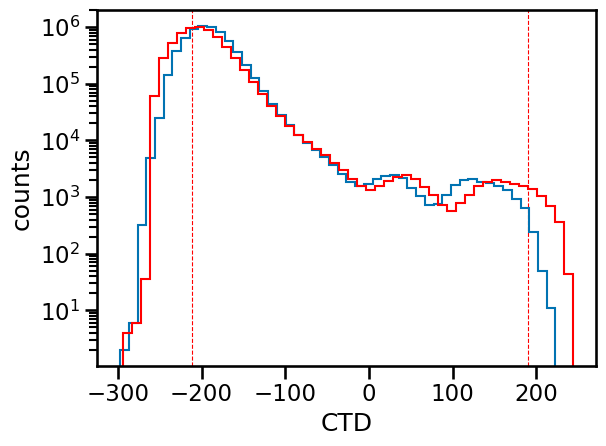

In [4]:
# AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
# DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
# allpaths = np.concatenate([AC_list, DC_list])
    
# path_lists = [AC_list, DC_list, allpaths]
# strings = ['Cs137allAC_preLL', 'Cs137allDC_preLL', 'Cs137allACandDC_preLL']

data_dict = {}
# for source in file_dict:
for source in file_dict:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allAC_preLL'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "CTD_" + string + ".pdf")

In [5]:
depth_plot_dict = {}
for source in data_dict:
    string = source + 'allAC_preLL'
    z_bins, e_trapping, h_trapping = make_depthplot(data_dict[source], string, zbin_dict[source], source=source)
    depth_plot_dict[source] = z_bins, e_trapping, h_trapping
    depth_correction(data_dict[source], z_bins, e_trapping, h_trapping, plot_dir=plot_dir, plot_suffix = string, source = source)
    with open('./depth_plot_'+string+'.txt', 'wb') as file:
        pickle.dump([z_bins, e_trapping, h_trapping], file)

FWHM = 3.678+/-0.041
FWTM = 8.888+/-0.028
FWHM = 3.385+/-0.009
FWTM = 7.948+/-0.01
FWHM = 2.511+/-0.004
FWTM = 5.147+/-0.009
FWHM = 2.595+/-0.003
FWTM = 5.079+/-0.007
FWHM = 2.859+/-0.004
FWTM = 6.628+/-0.007
FWHM = 2.861+/-0.004
FWTM = 6.04+/-0.068
FWHM = 2.333+/-0.002
FWTM = 4.438+/-0.004
FWHM = 2.328+/-0.002
FWTM = 4.463+/-0.002


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/COSITrapping/depth_helpers.py:632: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim((np.min(hist) + 10., 2.0*np.max(hist)))


FWHM = 4.576+/-0.338
FWTM = 16.173+/-0.388
FWHM = 4.142+/-0.174
FWTM = 11.881+/-0.205
FWHM = 3.027+/-0.115
FWTM = 5.874+/-0.222
FWHM = 2.889+/-0.137
FWTM = 5.791+/-0.298


/home/cosilab/COSITrapping/depth_helpers.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]
/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.695+/-0.0
FWTM = 5.968+/-0.0
FWHM = 3.01+/-0.0
FWTM = 6.537+/-0.0
FWHM = 2.171+/-0.0
FWTM = 5.167+/-0.0
FWHM = 2.474+/-0.0
FWTM = 5.948+/-0.0


In [6]:
param_dict = {}
for source in data_dict:
    string = source + 'allAC_preLL'
    m = fit_CCE(*depth_plot_dict[source], sim_dCCE, plot_dir=plot_dir, plot_suffix = string, trim_index = 1, source=source)
    depth_correction_CCE(data_dict[source], *m.values['ae','ah','b','c'], sim_dCCE, plot_dir=plot_dir, plot_suffix = string, source=source)
    param_dict[source] = m
    print(m)

FWHM = 3.678+/-0.041
FWTM = 8.888+/-0.028
FWHM = 3.402+/-0.007
FWTM = 7.906+/-0.013
FWHM = 2.511+/-0.004
FWTM = 5.147+/-0.009
FWHM = 2.617+/-0.002
FWTM = 5.102+/-0.003
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 210.2 (chi2/ndof = 3.8)    │              Nfcn = 347              │
│ EDM = 0.000133 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not force

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.695+/-0.0
FWTM = 5.968+/-0.0
FWHM = 2.877+/-0.0
FWTM = 6.301+/-0.0
FWHM = 2.171+/-0.0
FWTM = 5.167+/-0.0
FWHM = 2.324+/-0.0
FWTM = 5.856+/-0.0
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.797e+06 (chi2/ndof = 32097.1)│              Nfcn = 291              │
│ EDM = 7e-05 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────

In [7]:
for source in data_dict:
    string = source + 'allAC_preLL_Cs137params'
    depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *param_dict['Cs137'].values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)

FWHM = 3.678+/-0.041
FWTM = 8.888+/-0.028
FWHM = 3.402+/-0.007
FWTM = 7.906+/-0.013
FWHM = 2.511+/-0.004
FWTM = 5.147+/-0.009
FWHM = 2.617+/-0.002
FWTM = 5.102+/-0.003
FWHM = 2.859+/-0.004
FWTM = 6.628+/-0.007
FWHM = 2.864+/-0.003
FWTM = 6.032+/-0.026
FWHM = 2.333+/-0.002
FWTM = 4.438+/-0.004
FWHM = 2.345+/-0.002
FWTM = 4.461+/-0.003


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 4.576+/-0.338
FWTM = 16.173+/-0.388
FWHM = 4.224+/-0.488
FWTM = 12.809+/-0.643
FWHM = 3.027+/-0.115
FWTM = 5.874+/-0.222
FWHM = 2.904+/-0.075
FWTM = 5.662+/-0.205


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.695+/-0.0
FWTM = 5.968+/-0.0
FWHM = 2.509+/-0.0
FWTM = 5.806+/-0.0
FWHM = 2.171+/-0.0
FWTM = 5.167+/-0.0


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.391+/-0.0
FWTM = 5.606+/-0.0
